In [1]:
import pandas as pd
import numpy as np
import pytz
import matplotlib.pyplot as plt
from datetime import datetime
from statistics import variance as var
from scipy.fftpack import fft


In [2]:
df = pd.read_csv('./data.csv')
df = df.drop(['Unnamed: 0'], axis=1)
print(df.shape)
df.head()

(59897, 42)


,PowerDemand,time,temp_Denver,percent_pop_Denver,temp_Colorado Springs,percent_pop_Colorado Springs,temp_Aurora,percent_pop_Aurora,temp_Fort Collins,percent_pop_Fort Collins,...,temp_Lafayette,percent_pop_Lafayette,temp_Loveland,percent_pop_Loveland,temp_Broomfield,percent_pop_Broomfield,temp_Castle Rock,percent_pop_Castle Rock,temp_Commerce City,percent_pop_Commerce City
0,4875.0,2015-07-01 01:00:00-06:00,20.1,0.480486,22.2,0.107303,19.4,0.063353,19.0,0.052225,...,19.2,0.016644,19.0,0.013175,19.2,0.01177,21.1,0.011439,21.3,0.010078
1,4618.0,2015-07-01 02:00:00-06:00,19.5,0.480486,21.7,0.107303,18.8,0.063353,19.0,0.052225,...,17.2,0.016644,19.0,0.013175,17.2,0.01177,20.0,0.011439,20.2,0.010078
2,4427.0,2015-07-01 03:00:00-06:00,18.9,0.480486,19.4,0.107303,18.2,0.063353,18.0,0.052225,...,17.2,0.016644,18.0,0.013175,17.2,0.01177,18.3,0.011439,19.1,0.010078
3,4344.0,2015-07-01 04:00:00-06:00,18.5,0.480486,19.4,0.107303,17.8,0.063353,18.0,0.052225,...,16.8,0.016644,18.0,0.013175,16.8,0.01177,17.2,0.011439,19.6,0.010078
4,4374.0,2015-07-01 05:00:00-06:00,17.8,0.480486,16.7,0.107303,17.1,0.063353,17.0,0.052225,...,15.7,0.016644,17.0,0.013175,15.7,0.01177,18.3,0.011439,19.6,0.010078


In [3]:
# Create single time series of temperature weighted by population
weighted_temp = np.zeros(df.shape[0])
for col in df.columns:
    if col not in ['PowerDemand', 'time'] and not col.startswith('percent_pop'):
        city = col.split('_')[1]
        weighted_temp += df[col] * df['percent_pop_' + city]
        
final = df.iloc[:,0:2]
final['WeightedTemp'] = weighted_temp
final.time = pd.to_datetime(final.time)
final.head()

,PowerDemand,time,WeightedTemp
0,4875.0,2015-07-01 01:00:00-06:00,20.530496
1,4618.0,2015-07-01 02:00:00-06:00,19.708924
2,4427.0,2015-07-01 03:00:00-06:00,18.780578
3,4344.0,2015-07-01 04:00:00-06:00,18.468283
4,4374.0,2015-07-01 05:00:00-06:00,17.556280


In [4]:
# convert to datetime format
tz = pytz.timezone('US/Mountain')       # add timezone info

times = [t.replace(tzinfo=None) for t in final.time]     # first, save the time as unaware datetime
final['time_unaware'] = times
final['time_unaware'] = pd.to_datetime(final['time_unaware'])

times = [tz.localize(t) for t in final.time_unaware]     # add timezone info to unaware time
final['time'] = times
final = final.drop(['time_unaware'], axis=1)
final.head()

,PowerDemand,time,WeightedTemp
0,4875.0,2015-07-01 01:00:00-06:00,20.530496
1,4618.0,2015-07-01 02:00:00-06:00,19.708924
2,4427.0,2015-07-01 03:00:00-06:00,18.780578
3,4344.0,2015-07-01 04:00:00-06:00,18.468283
4,4374.0,2015-07-01 05:00:00-06:00,17.556280


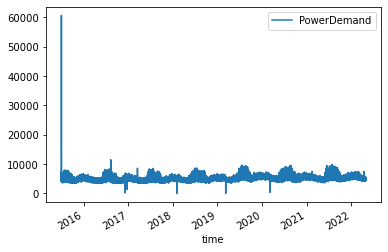

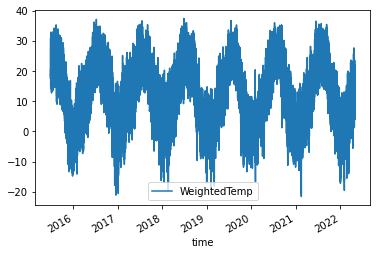

In [5]:
final.plot(x='time', y='PowerDemand')
final.plot(x='time', y='WeightedTemp')
final = final.rename(columns={'PowerDemand' : 'EnergyDemand'})

Original shape:  (59897, 3)
Q1:  4615.0
Q3:  5703.0


/var/folders/c7/911byk5d5jl0vp7m92bxn01w0000gn/T/ipykernel_33749/3849089776.py:8: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they. (Deprecated NumPy 1.22)
  Q1 = np.percentile(final.EnergyDemand, 25, interpolation='midpoint')
/var/folders/c7/911byk5d5jl0vp7m92bxn01w0000gn/T/ipykernel_33749/3849089776.py:9: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they. (Deprecated NumPy 1.22)
  Q3 = np.percentile(final.EnergyDemand, 75, interpolation='midpoint')


<AxesSubplot:>

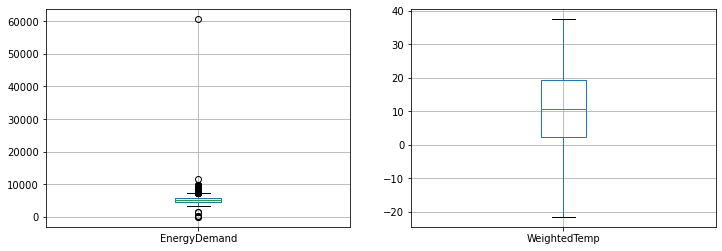

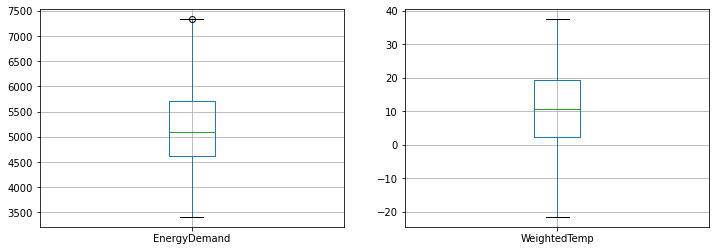

In [6]:
# Remove outliers using interquartile range (IQR) 
print('Original shape: ', final.shape)
fig, ax = plt.subplots(1,2, figsize=(12,4))
final.boxplot('EnergyDemand', ax=ax[0])
final.boxplot('WeightedTemp', ax=ax[1])

# Lots of outliers in PowerDemand, none in WeightedTemp
Q1 = np.percentile(final.EnergyDemand, 25, interpolation='midpoint')
Q3 = np.percentile(final.EnergyDemand, 75, interpolation='midpoint')
IQR = Q3 - Q1
print('Q1: ', Q1)
print('Q3: ', Q3)

upper = np.where(final.EnergyDemand >= (Q3 + 1.5*IQR))
lower = np.where(final.EnergyDemand <= (Q1 - 1.5*IQR))

final.loc[upper[0].tolist(),'EnergyDemand'] = None
final.loc[lower[0].tolist(),'EnergyDemand'] = None

final.EnergyDemand.interpolate(inplace=True)

fig, ax = plt.subplots(1,2, figsize=(12,4))
final.boxplot('EnergyDemand', ax=ax[0])
final.boxplot('WeightedTemp', ax=ax[1])

Variance of WeightedTemp:  118.8338506359839


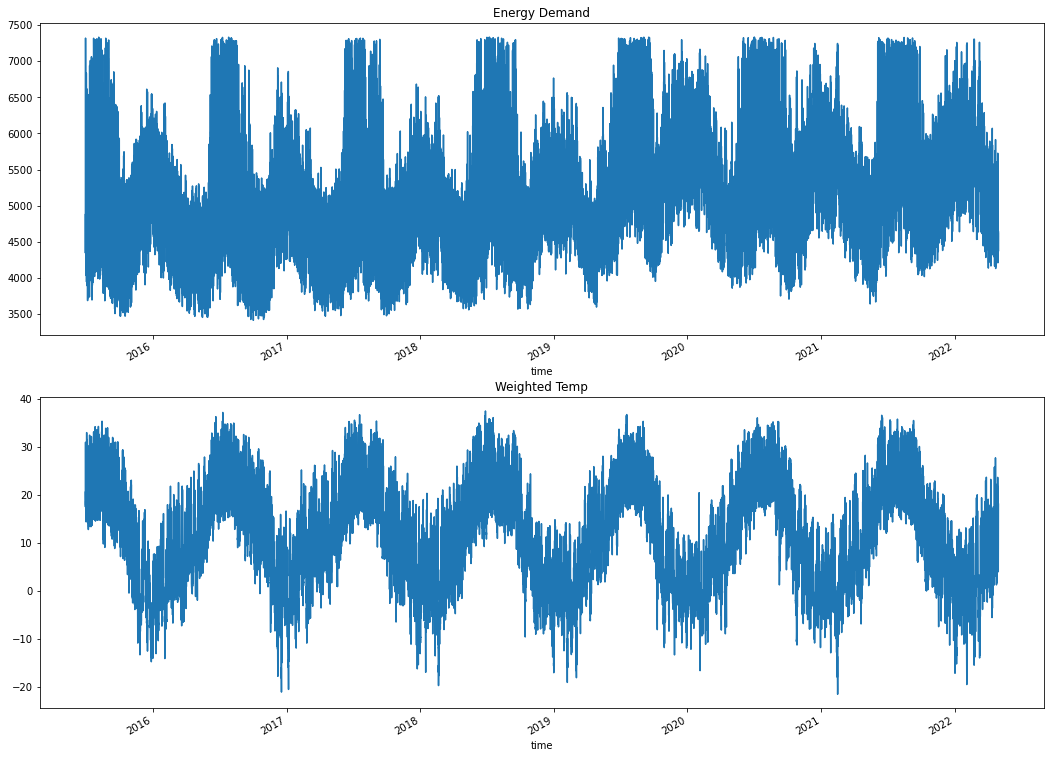

In [7]:
# Plot all data
fig, ax = plt.subplots(2,1, figsize=(18,14))
final.plot(x='time', y='EnergyDemand', ax=ax[0], legend=False, title='Energy Demand')
final.plot(x='time', y='WeightedTemp', ax=ax[1], legend=False, title='Weighted Temp');
           
# print('Variance of PowerDemand: ', var(final.PowerDemand))
print('Variance of WeightedTemp: ', var(final.WeightedTemp))

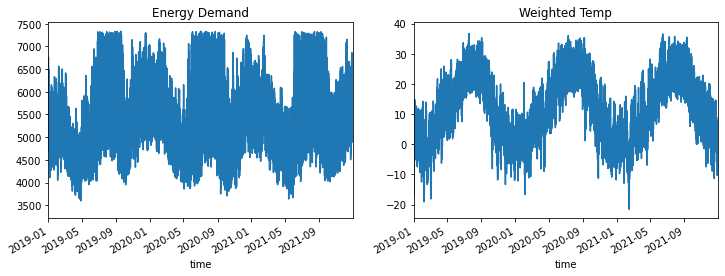

In [9]:
# Plot 3 years of data
fig, ax = plt.subplots(1,2, figsize=(12,4))
final.plot(x='time', y='EnergyDemand', xlim=('2019-01-01', '2022-01-01'), ax=ax[0], legend=False, title='Energy Demand')
final.plot(x='time', y='WeightedTemp', xlim=('2019-01-01', '2022-01-01'), ax=ax[1], legend=False, title='Weighted Temp');

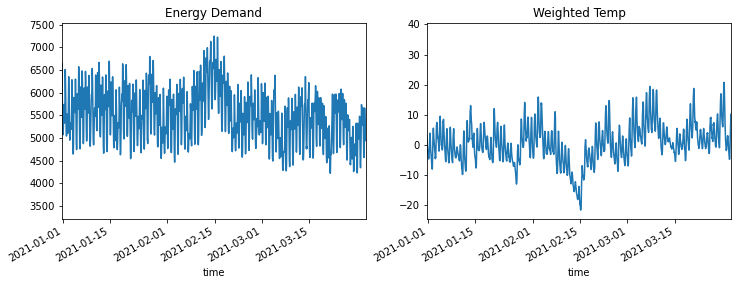

In [10]:
# Plot 3 months of data
fig, ax = plt.subplots(1,2, figsize=(12,4))
final.plot(x='time', y='EnergyDemand', xlim=('2021-01-01', '2021-04-01'), ax=ax[0], legend=False, title='Energy Demand')
final.plot(x='time', y='WeightedTemp', xlim=('2021-01-01', '2021-04-01'), ax=ax[1], legend=False, title='Weighted Temp');

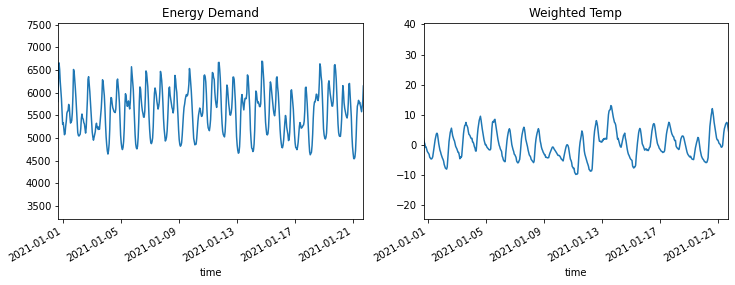

In [11]:
# Plot 3 weeks of data
fig, ax = plt.subplots(1,2, figsize=(12,4))
final.plot(x='time', y='EnergyDemand', xlim=('2021-01-01', '2021-01-22'), ax=ax[0], legend=False, title='Energy Demand')
final.plot(x='time', y='WeightedTemp', xlim=('2021-01-01', '2021-01-22'), ax=ax[1], legend=False, title='Weighted Temp');

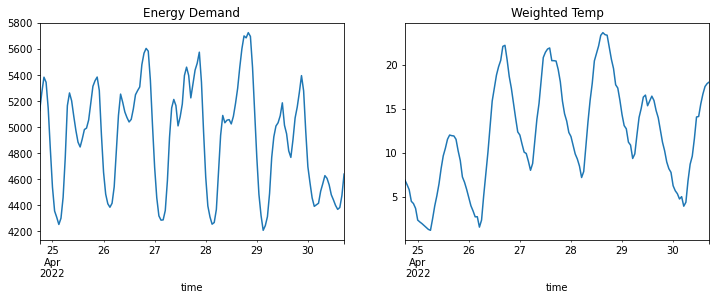

In [12]:
# Plot 3 days of data
fig, ax = plt.subplots(1,2, figsize=(12,4))
day = final.iloc[-144:,:]
day.plot(x='time', y='EnergyDemand', ax=ax[0], legend=False, title='Energy Demand')
ax[0].axvline(datetime(2022,4,18,8,0,0), c='k', ls='dotted')
ax[0].axvline(datetime(2022,4,19,8,0,0), c='k', ls='dotted')
ax[0].axvline(datetime(2022,4,20,8,0,0), c='k', ls='dotted')
ax[0].axvline(datetime(2022,4,21,8,0,0), c='k', ls='dotted')
ax[0].axvline(datetime(2022,4,22,8,0,0), c='k', ls='dotted')
ax[0].axvline(datetime(2022,4,23,8,0,0), c='k', ls='dotted')

ax[0].axvline(datetime(2022,4,18,21,0,0), c='r', ls='dotted')
ax[0].axvline(datetime(2022,4,19,21,0,0), c='r', ls='dotted')
ax[0].axvline(datetime(2022,4,20,21,0,0), c='r', ls='dotted')
ax[0].axvline(datetime(2022,4,21,21,0,0), c='r', ls='dotted')
ax[0].axvline(datetime(2022,4,22,21,0,0), c='r', ls='dotted')
ax[0].axvline(datetime(2022,4,23,21,0,0), c='r', ls='dotted')

day.plot(x='time', y='WeightedTemp', ax=ax[1], legend=False, title='Weighted Temp');
ax[1].axvline(datetime(2022,4,18,8,0,0), c='k', ls='dotted')
ax[1].axvline(datetime(2022,4,19,8,0,0), c='k', ls='dotted')
ax[1].axvline(datetime(2022,4,20,8,0,0), c='k', ls='dotted')
ax[1].axvline(datetime(2022,4,21,8,0,0), c='k', ls='dotted')
ax[1].axvline(datetime(2022,4,22,8,0,0), c='k', ls='dotted')
ax[1].axvline(datetime(2022,4,23,8,0,0), c='k', ls='dotted')

ax[1].axvline(datetime(2022,4,18,21,0,0), c='r', ls='dotted')
ax[1].axvline(datetime(2022,4,19,21,0,0), c='r', ls='dotted')
ax[1].axvline(datetime(2022,4,20,21,0,0), c='r', ls='dotted')
ax[1].axvline(datetime(2022,4,21,21,0,0), c='r', ls='dotted')
ax[1].axvline(datetime(2022,4,22,21,0,0), c='r', ls='dotted')
ax[1].axvline(datetime(2022,4,23,21,0,0), c='r', ls='dotted')

In [13]:
final.to_csv('./cleaned.csv', index=False)

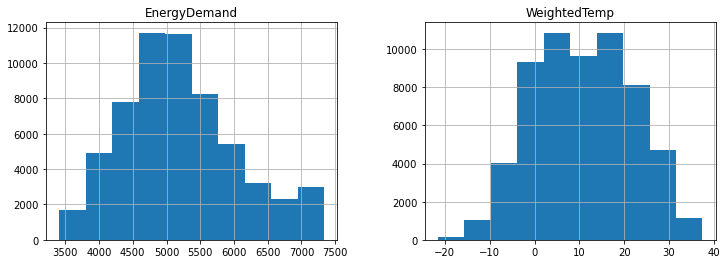

In [14]:
fig, ax = plt.subplots(1,2, figsize=(12,4))
final.hist(column='EnergyDemand', ax=ax[0])
final.hist(column='WeightedTemp', ax=ax[1]);

<AxesSubplot:xlabel='WeightedTemp', ylabel='EnergyDemand'>

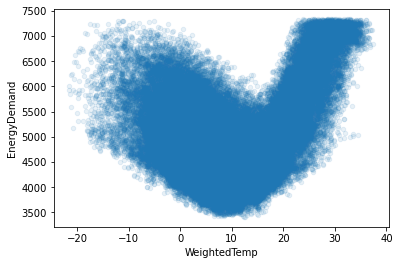

In [15]:
final.plot(x='WeightedTemp', y='EnergyDemand', kind='scatter', alpha=0.1)

<AxesSubplot:xlabel='WeightedTemp', ylabel='EnergyDemand'>

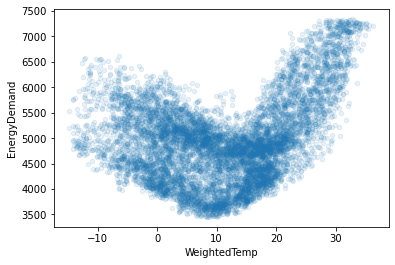

In [16]:
final.iloc[0:int(24*365),:].plot(x='WeightedTemp', y='EnergyDemand', kind='scatter', alpha=0.1)